# CS145 Introduction to Data Mining - Assignment 5
## Deadline: 11:59PM (midnight), May 17, 2024

## Instructions
Each assignment is structured as a Jupyter notebook, offering interactive tutorials that align with our lectures. You will encounter two types of problems: *write-up problems* and *coding problems*.

1. **Write-up Problems:** These problems are primarily theoretical, requiring you to demonstrate your understanding of lecture concepts and to provide mathematical proofs for key theorems. Your answers should include sufficient steps for the mathematical derivations.
2. **Coding Problems:** Here, you will be engaging with practical coding tasks. These may involve completing code segments provided in the notebooks or developing models from scratch.

To ensure clarity and consistency in your submissions, please adhere to the following guidelines:

* For write-up problems, use Markdown bullet points to format text answers. Also, express all mathematical equations using $\LaTeX$ and avoid plain text such as `x0`, `x^1`, or `R x Q` for equations.
* For coding problems, comment on your code thoroughly for readability and ensure your code is executable. Non-runnable code may lead to a loss of **all** points. Coding problems have automated grading, and altering the grading code will result in a deduction of **all** points.
* Your submission should show the entire process of data loading, preprocessing, model implementation, training, and result analysis. This can be achieved through a mix of explanatory text cells, inline comments, intermediate result displays, and experimental visualizations.

### Collaboration and Integrity

* Collaboration is encouraged, but all final submissions must be your own work. Please acknowledge any collaboration or external sources used, including websites, papers, and GitHub repositories.
* Any suspicious cases of academic misconduct will be reported to The Office of the Dean of Students.

## Before You Start

Useful information about managing environments can be found [here](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html).

You may also quickly review the usage of basic Python and Numpy package, if needed in coding for matrix operations.

In this notebook, you must not delete any code cells in this notebook. If you change any code outside the blocks that you are allowed to edit (between `START/END YOUR CODE HERE`), you need to highlight these changes. You may add some additional cells to help explain your results and observations.

#### GPU Support

Considering the size of the training data, it is strongly suggested to use [Google Colab](https://colab.research.google.com/) or a GPU server for this exercise. If you are using Colab, you can manually switch to a CPU device on Colab by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`.

In [18]:
import torch

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
elif USE_GPU and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [19]:
import scipy
import numpy as np
import networkx as nx

from torch import nn
from torch.nn import functional as F
from sklearn.cluster import KMeans

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

## Part 1: Variational Autoencoders (40 points)

## Brush-up of Information Theory

Many machine learning and deep learning methods are based on a variety of concepts from probability theory and information theory. 

Since Variational AutoEncoders are very intensive on this aspect, it can be useful to brush up some fundamentals.

If you are not already confident with the concepts of marginal probability, Shannon entropy, cross-entropy, Kullback–Leibler divergence and mutual information, we suggest you a fast reading, this [blog post](http://colah.github.io/posts/2015-09-Visual-Information/) with awesome visualizations by Chris Olah; and a book reference, [*Information Theory, Inference, and Learning Algorithms*](https://www.inference.org.uk/itprnn/book.pdf) by David J.C. MacKay.


#### Reparameterization trick

We need the reparameterization trick in order to backpropagate through a random node. 


Given:

In [20]:
# Some data
data = torch.rand(10)

# Some parameters to train
deterministic_transform1 = torch.nn.Linear(in_features=10,  out_features=10)
deterministic_transform2 = torch.nn.Linear(in_features=10,  out_features=10)

# My expected output
gold_output = torch.ones(10)

We want optimize the parameters in order to obtain `gold_output` from the following computation:

In [21]:
# My stochastic prediction
pred_mean = deterministic_transform1(data)
pred_std = torch.ones_like(data)

sampling = torch.normal(mean=pred_mean, std=pred_std)     # random numbers drawn from **separate** normal distributions
                                                          # whose mean and standard deviation are given.

pred_output = deterministic_transform2(sampling)

# Error function
loss = F.mse_loss(pred_output, gold_output)
deterministic_transform1.zero_grad()
loss.backward()

# then optimize with some optimizer

But...

In [22]:
print(loss)
print(deterministic_transform1.weight.grad  )

tensor(1.5239, grad_fn=<MseLossBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


We have a problem, this doesn’t work! We don’t have any gradients! They are zero even though the loss is non-zero



The specific problem here is that we can’t backpropagate through the random `normal` function. 

This makes sense right? We are trying to back propagate through a random/stochastic node in the computational graph. 
It doesn’t make much sense to differentiate with respect to a stochastic node since that means the gradient would technically be a random variable too!

So let’s... reparametrize! That is, let’s change how the parameters are incorporated into the model.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/trick.png)


### Problem 1 (10 points)

Implement the `reparameterize` function that takes the mean `mu` and log-variance `logvar` as input.
In this function, compute the standard deviation from the log-variance using the exponential function.
Then, sample a random noise from a standard normal distribution with the same shape as the standard deviation.
Finally, compute the sampled latent vector `z` using the reparameterization trick.
Return the sampled latent vector `z`.

Note that here using the log-variance instead of the standard deviation improves numerical stability during training.
The log-variance is used to compute the standard deviation by applying the exponential function: `std = exp(0.5 * logvar)`.

In [23]:
def reparameterize(mu, logvar):
    """
    Reparameterization trick to sample from N(mu, var) from N(0, 1).

    Args:
        mu: Mean of the latent Gaussian [batch_size, latent_dim]
        logvar: Log variance of the latent Gaussian [batch_size, latent_dim]

    Returns:
        z: Sampled latent vector [batch_size, latent_dim]
    """

    eps = torch.randn_like(mu)  # Sample random noise from a standard normal distribution
    # START YOUR CODE HERE
    std = torch.exp(0.5 * logvar)  # Compute the standard deviation from the log-variance
    z = eps * std + mu  # Compute the sampled latent vector using the reparameterization trick
    # END YOUR CODE HERE

    return z

In [24]:
# Test case for reparameterize function
mu = torch.tensor([[0.0, 0.0]])
logvar = torch.tensor([[1.0, 1.0]])
z = reparameterize(mu, logvar)
assert z.shape == (1, 2), "Output shape of reparameterize should be (1, 2)"

In [25]:
# My stochastic prediction
pred_mean = deterministic_transform1(data)
pred_std = torch.ones_like(data)

rand_source = torch.randn(10)                       # random numbers drawn from **separate** canonical normal distributions
sampling = reparameterize(pred_mean, pred_std)

pred_output = deterministic_transform2(sampling)

# My error
loss = F.mse_loss(pred_output, gold_output)
deterministic_transform1.zero_grad()
loss.backward()

# then optimize with some optimizer

In [26]:
deterministic_transform1.weight.grad

tensor([[ 0.3408,  0.3387,  0.2224,  0.1080,  0.4169,  0.1026,  0.2560,  0.0820,
          0.3301,  0.2186],
        [ 0.2418,  0.2403,  0.1578,  0.0767,  0.2958,  0.0728,  0.1817,  0.0582,
          0.2342,  0.1551],
        [ 0.1714,  0.1703,  0.1118,  0.0543,  0.2097,  0.0516,  0.1288,  0.0412,
          0.1660,  0.1099],
        [ 0.0769,  0.0765,  0.0502,  0.0244,  0.0941,  0.0232,  0.0578,  0.0185,
          0.0745,  0.0494],
        [-0.0443, -0.0440, -0.0289, -0.0140, -0.0542, -0.0133, -0.0333, -0.0107,
         -0.0429, -0.0284],
        [-0.2267, -0.2253, -0.1479, -0.0719, -0.2773, -0.0682, -0.1703, -0.0545,
         -0.2196, -0.1454],
        [ 0.0202,  0.0201,  0.0132,  0.0064,  0.0247,  0.0061,  0.0152,  0.0049,
          0.0196,  0.0130],
        [-0.0113, -0.0112, -0.0074, -0.0036, -0.0138, -0.0034, -0.0085, -0.0027,
         -0.0109, -0.0072],
        [-0.2020, -0.2008, -0.1318, -0.0641, -0.2471, -0.0608, -0.1518, -0.0486,
         -0.1957, -0.1296],
        [-0.0018, -

That's it, now we can adjust the parameters of the distribution to improve our stochastic prediction!

**We constructed the parameterized random variable via a parameterized deterministic function of a parameter-free random variable.**



Another way of thinking about it is that we have moved the source of noise outside of the main flow of the network and used the noise as a way to sample from the expectation.

For a formal explanation check out this [post](https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important).

### Problem 2 (10 points)

### Implementing a VAE

Let $x$ be the input, $z$ the latent variable, $θ$ the decoder parameters, and $φ$ the encoder parameters.
Show that the VAE training objective $\log p_\theta(x)$ consists of two terms:
1. Reconstruction loss
2. KL divergence between the encoded latent distribution $q_φ(z\mid x)$ and $p(z)$, the prior distribution 

**Answer:**

Start with the log-likelihood of a data point $\bm{x}$:
$$\begin{align*}
\log p(\bm{x}) = \log \int p(\bm{x}, \bm{z}) \mathrm{d}\bm{z} = \log \int p(\bm{x} \mid \bm{z}) p(\bm{z}) \mathrm{d}\bm{z}
\end{align*}$$

Introduce a variational distribution $q(\bm{z} \mid \bm{x})$ and use Jensen's inequality:
$$\begin{align*}
\log p(\bm{x}) &= \log \int q(\bm{z} \mid \bm{x}) \frac{p(\bm{x} \mid \bm{z}) p(\bm{z})}{q(\bm{z} \mid \bm{x})} \mathrm{d}\bm{z} \\
&\geq \int q(\bm{z} \mid \bm{x}) \log \frac{p(\bm{x} \mid \bm{z}) p(\bm{z})}{q(\bm{z} \mid \bm{x})} \mathrm{d}\bm{z} \\
&= \int q(\bm{z} \mid \bm{x}) \log p(\bm{x} \mid \bm{z}) \mathrm{d}\bm{z} - \int q(\bm{z} \mid \bm{x}) \log \frac{q(\bm{z} \mid \bm{x})}{p(\bm{z})} \mathrm{d}\bm{z} \\
&= \mathbb{E}_{q(\bm{z} \mid \bm{x})}[\log p(\bm{x} \mid \bm{z})] - D_{\mathrm{KL}}(q(\bm{z} \mid \bm{x}) \parallel p(\bm{z}))
\end{align*}$$

### Problem 3 (10 points)

Instructions:
- Implement the `VAE` model class with an encoder and a decoder.
- The encoder outputs the mean `mu` and log-variance `logvar` of the latent Gaussian distribution.
- The decoder reconstructs the input data from the sampled latent vector.
- Implement the `forward` method to perform the encoding, sampling, and decoding process.
- Implement the `loss_function` method to compute the VAE loss.

In [32]:
class VAE(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=64, latent_dim=20):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels*2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(hidden_channels*2*7*7, latent_dim*2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_channels*2*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (hidden_channels*2, 7, 7)),
            nn.ConvTranspose2d(in_channels=hidden_channels*2, out_channels=hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=input_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

        self.latent_dim = latent_dim

    def encode(self, x):
        """
        Encodes the input into parameters of a latent Gaussian distribution.
        """
        x = self.encoder(x)
        mu, logvar = x[:, :self.latent_dim], x[:, self.latent_dim:]
        return mu, logvar

    def decode(self, z):
        """
        Decodes the latent vector into reconstructed input data.
        """
        return self.decoder(z)

    def forward(self, x):
        # START YOUR CODE HERE
        mu, log_var = self.encode(x)  # Encode the input to obtain mean and log-variance of the latent Gaussian
        z = reparameterize(mu, log_var)  # Sample the latent vector using the reparameterization trick
        recon_x = self.decode(z)  # Decode the latent vector to obtain the reconstructed input
        # END YOUR CODE HERE
        return recon_x, mu, log_var

    def loss_function(self, recon_x, x, mu, log_var):
        """
        Computes the VAE loss function.
        """
        # START YOUR CODE HERE
        recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')  # Reconstruction loss
        kl_div = ((- log_var.sum(-1) - self.latent_dim + torch.exp(log_var).sum(-1) + (mu ** 2).sum(-1)) / 2).mean()  # KL divergence loss
        loss = recon_loss + kl_div 
        # Total VAE loss
        # END YOUR CODE HERE
        return loss


#### **Encoder and Decoder**
We'll use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

**Bottleneck**

In the convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.


**Deconvolution**

In the decoder we are using a transposed convolution, also known as deconvolution. You can think of it as the convolution in the opposite direction.  ([here](https://github.com/vdumoulin/conv_arithmetic) more visualizations)

*Blue maps are inputs, and cyan maps are outputs*

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/deconv.gif)



**Kernel size**

We are using `kernel_size=4`. The motivation behind this choice is to lessen the checkerboard artifacts described [here](https://distill.pub/2016/deconv-checkerboard)

### Problem 4 (10 points)

Instructions:
- Train the VAE model on the MNIST dataset for a specified number of epochs.
- Plot the training loss over epochs.
- Visualize the learned latent space by sampling points from the latent space and decoding them.
- Analyze the structure of the latent space and discuss your observations.

Epoch [1/50], Loss: 16636.0098
Epoch [2/50], Loss: 15663.3457
Epoch [3/50], Loss: 15012.5469
Epoch [4/50], Loss: 15410.8574
Epoch [5/50], Loss: 14942.5664
Epoch [6/50], Loss: 14587.1924
Epoch [7/50], Loss: 14874.4375
Epoch [8/50], Loss: 14213.2021
Epoch [9/50], Loss: 15158.1611
Epoch [10/50], Loss: 14012.2314
Epoch [11/50], Loss: 13576.1943
Epoch [12/50], Loss: 14065.3613
Epoch [13/50], Loss: 13625.3223
Epoch [14/50], Loss: 13710.2334
Epoch [15/50], Loss: 13912.0615
Epoch [16/50], Loss: 14841.3418
Epoch [17/50], Loss: 14283.4463
Epoch [18/50], Loss: 12520.9805
Epoch [19/50], Loss: 14925.8848
Epoch [20/50], Loss: 13715.5010
Epoch [21/50], Loss: 13355.9170
Epoch [22/50], Loss: 13675.8193
Epoch [23/50], Loss: 13250.0059
Epoch [24/50], Loss: 13774.9844
Epoch [25/50], Loss: 13741.6250
Epoch [26/50], Loss: 14016.9932
Epoch [27/50], Loss: 13875.8506
Epoch [28/50], Loss: 13861.2207
Epoch [29/50], Loss: 14111.6934
Epoch [30/50], Loss: 13918.2246
Epoch [31/50], Loss: 13129.6436
Epoch [32/50], Lo

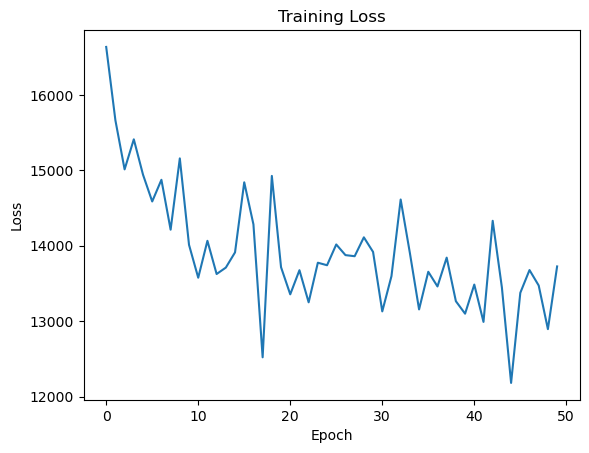

In [33]:
num_epochs = 50
batch_size = 128
learning_rate = 1e-3

dataset = MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = VAE(hidden_channels=64, latent_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_history = []
for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        recon_batch, mu, log_var = model(data)
        loss = model.loss_function(recon_batch, data, mu, log_var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_history.append(loss.item())
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Plot the training loss
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

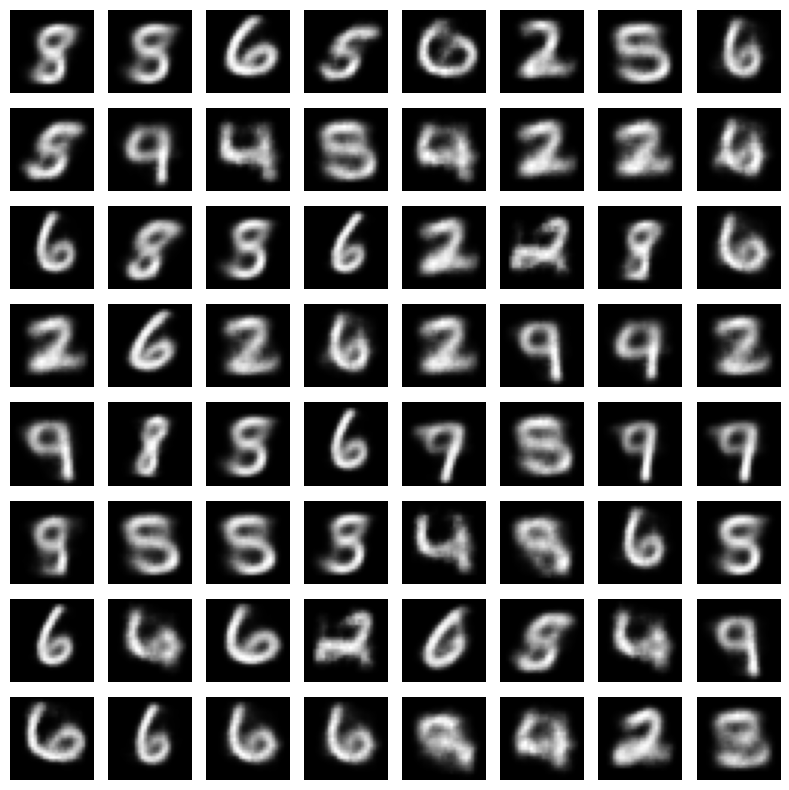

In [34]:
with torch.no_grad():
    # Sample latent vectors from the prior distribution
    prior_samples = torch.randn(64, 2).to(device)  # Sample 64 points from the prior distribution
    generated_samples = model.decode(prior_samples).view(64, 1, 28, 28).detach().cpu()
    
    plt.figure(figsize=(8, 8))
    for i in range(64):
        plt.subplot(8, 8, i+1)
        plt.imshow(generated_samples[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

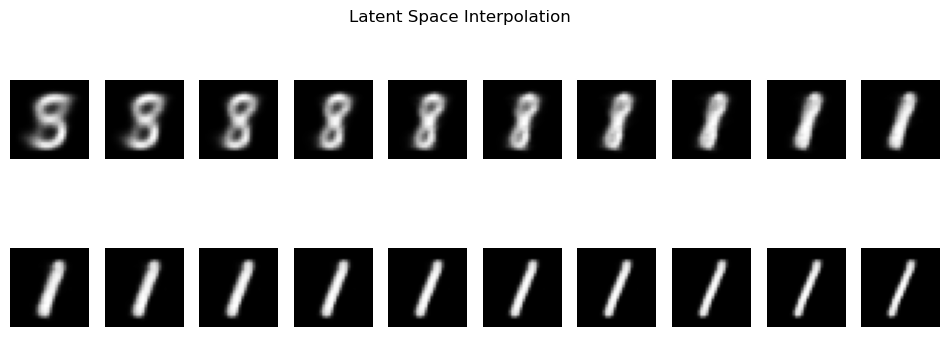

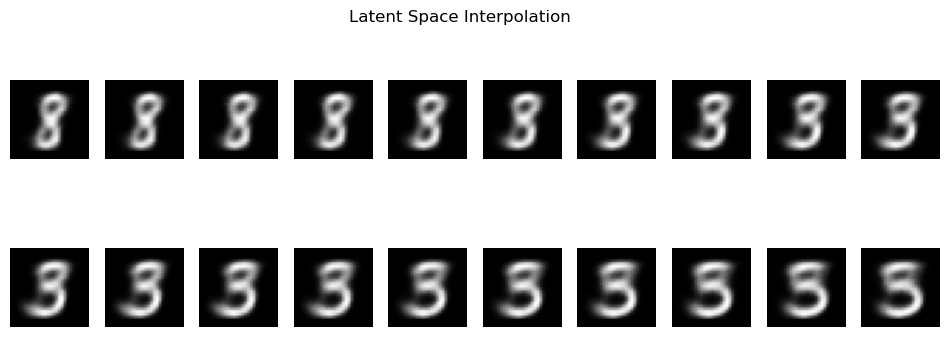

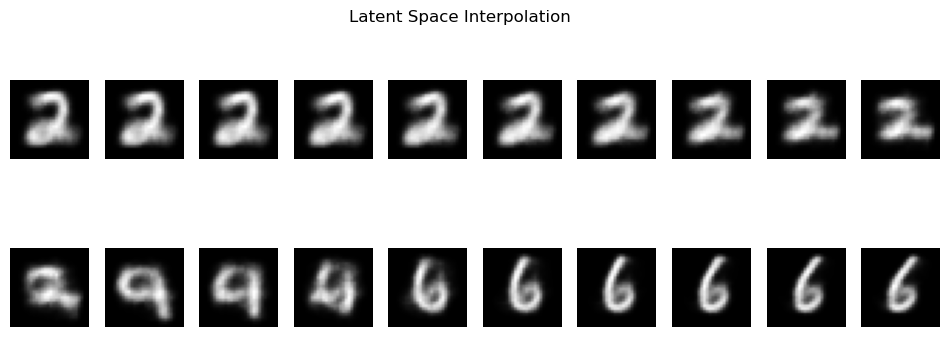

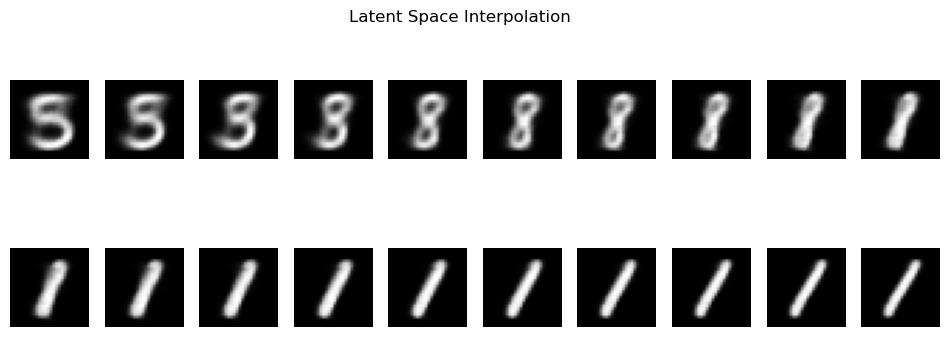

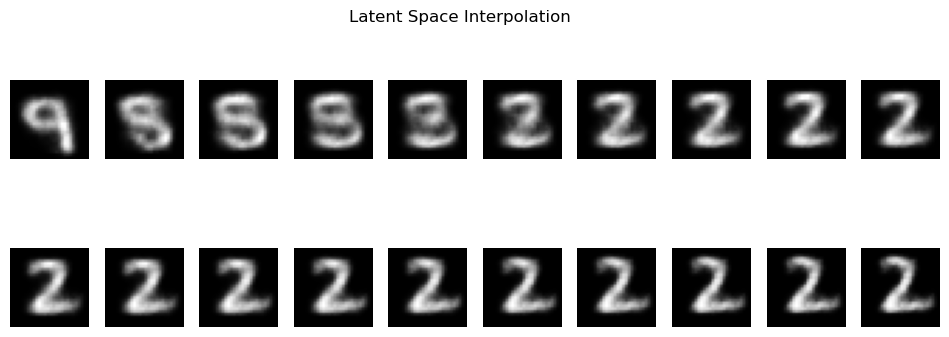

In [37]:
with torch.no_grad():
    for _ in range(5):
        # Select two random images from the test set
        img1, _ = dataset[np.random.randint(len(dataset))]
        img2, _ = dataset[np.random.randint(len(dataset))]

        # Encode the images into latent vectors
        z1 = model.encode(img1.view(1, 1, 28, 28).to(device))[0]
        z2 = model.encode(img2.view(1, 1, 28, 28).to(device))[0]

        # Interpolate between the latent vectors
        interpolations = []
        for alpha in np.linspace(0, 1, 20):
            z_interp = alpha * z1 + (1 - alpha) * z2
            interpolations.append(model.decode(z_interp).view(1, 28, 28))

        interpolations = torch.cat(interpolations)

        plt.figure(figsize=(12, 4))
        for i in range(20):
            plt.subplot(2, 10, i+1)
            plt.imshow(interpolations[i].squeeze().detach().cpu(), cmap='gray')
            plt.axis('off')
        plt.suptitle('Latent Space Interpolation')
        plt.show()

**Observations:**
- The training loss should decrease over epochs, indicating that the VAE is learning to reconstruct the input data.
- The visualized samples from the latent space should resemble handwritten digits, demonstrating that the VAE has learned a meaningful latent representation.
- The latent space should exhibit a structured organization, with similar digits clustered together and smooth transitions between different digits.
- The VAE has captured the underlying generative factors of the data in a low-dimensional latent space.


This shows the VAE has learned a meaningful, low-dimensional representation of the data.

### Latent space (from Jeremy Jordan's [blog post](https://www.jeremyjordan.me/variational-autoencoders/))

Using VAEs we are able to learn **smooth latent state representations** of the input data. For standard autoencoders, we simply need to learn an encoding which allows us to reproduce the input. 

As you can see in the left-most figure, focusing only on reconstruction loss does allow us to separate out the classes (in this case, MNIST digits) which should allow our decoder model the ability to reproduce the original handwritten digit, but there's an uneven distribution of data within the latent space. In other words, there are areas in latent space which don't represent any of our observed data.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/latent.png)



On the flip side, if we only focus only on ensuring that the latent distribution is similar to the prior distribution (through our KL divergence loss term), we end up describing every observation using the same unit Gaussian, which we subsequently sample from to describe the latent dimensions visualized. This effectively treats every observation as having the same characteristics; in other words, we've failed to describe the original data.

However, when the two terms are optimized simultaneously, we're encouraged to describe the latent state for an observation with distributions close to the prior but deviating when necessary to describe salient features of the input.

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/08/distr.png)

#### 2D Latent Space

The figure below visualizes the data generated by the decoder network of a variational autoencoder trained on the MNIST handwritten digits dataset. 

We are doing a linear interpolation over a (multivariate) gaussian distribution!

Here, we sample and decode latent space coordinates proportionally to the model’s distribution over latent space. In other words, we simply sample relative to our chosen prior distribution over z
. In our case, this means sampling linearly spaced percentiles from the [inverse CDF](http://work.thaslwanter.at/Stats/html/statsDistributions.html#other-important-presentations-of-probability-densities) of a spherical Gaussian.

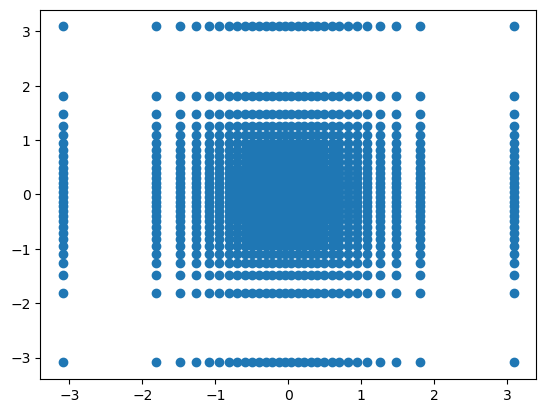

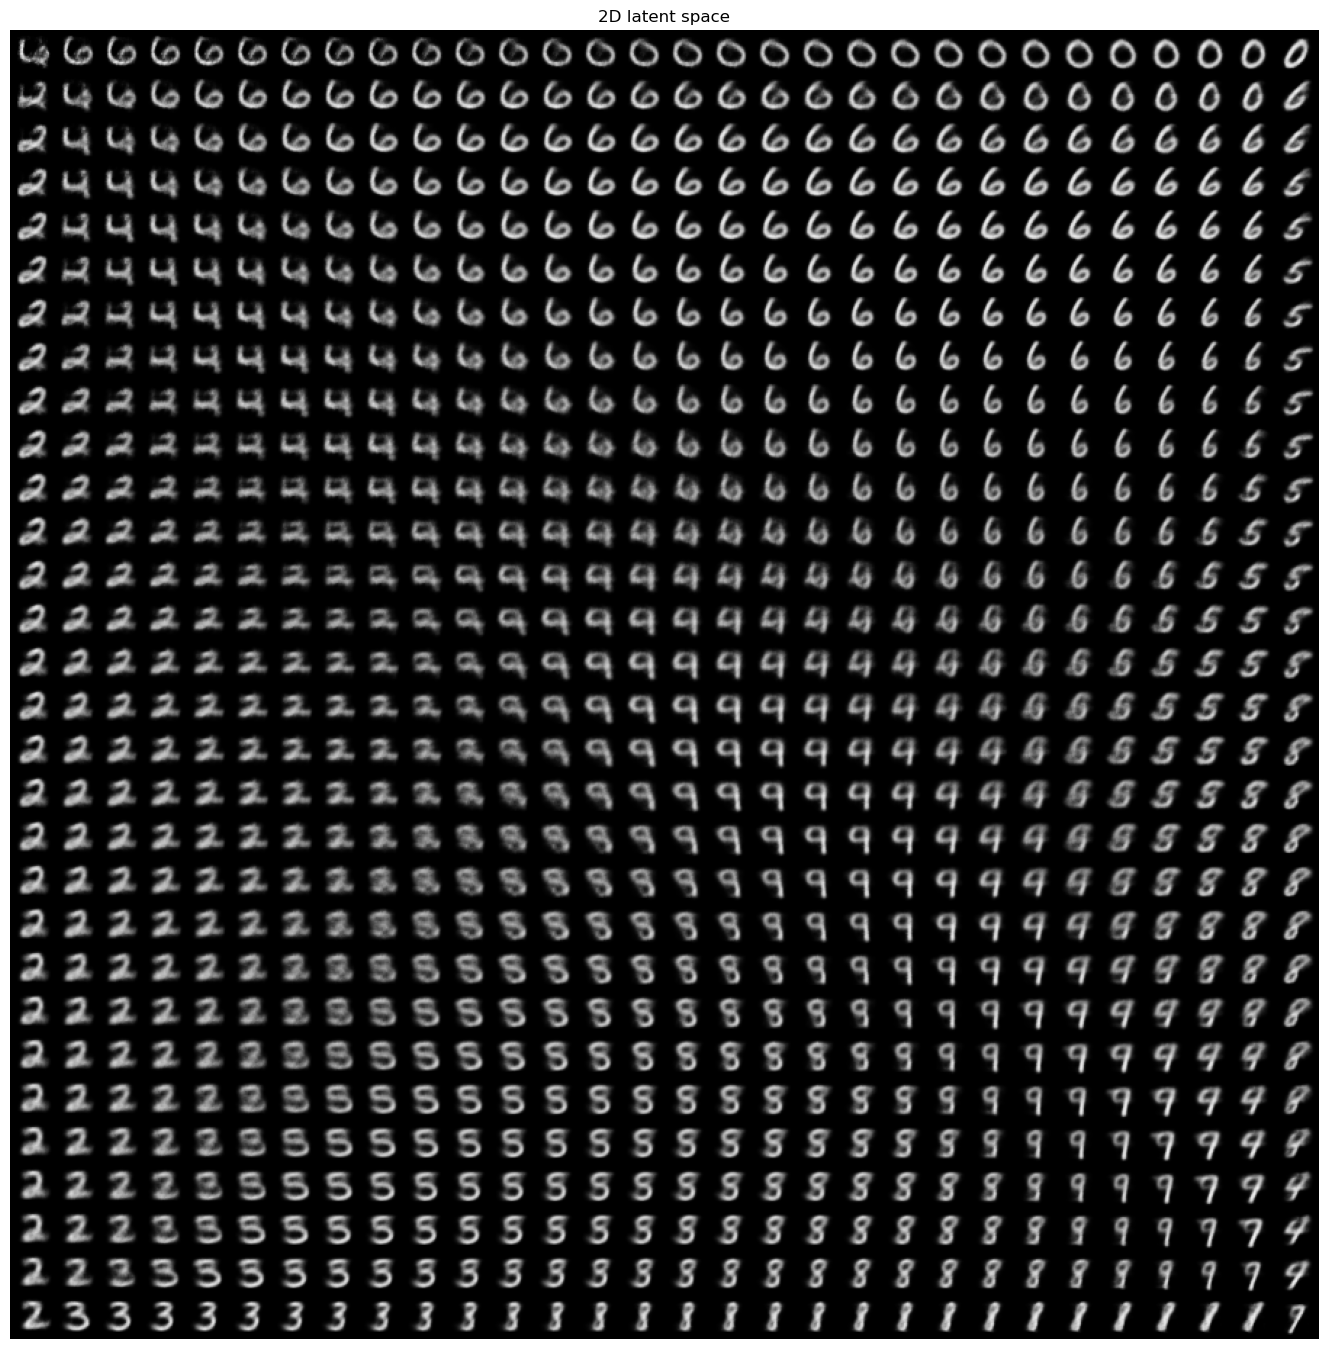

In [39]:
import torchvision
import matplotlib.pyplot as plt

latents_lims = 3.66
num_interpolations = 30

nd = torch.distributions.Normal(loc=torch.as_tensor([0.]),
                                scale=torch.as_tensor([1.]))

with torch.no_grad():
    latent_interpolation = torch.linspace(0.001, 0.999, num_interpolations)
    latent_grid = torch.stack(
        (
            latent_interpolation.repeat(num_interpolations, 1),
            latent_interpolation[:, None].repeat(1, num_interpolations)
        ), dim=-1).view(-1, 2)

    latent_grid = nd.icdf(latent_grid)
    plt.scatter(latent_grid[:,0].cpu().numpy(), latent_grid[:,1].cpu().numpy())
    plt.show()
    # reconstruct images from the latent vectors
    latent_grid = latent_grid.to(device)
    image_recon = model.decoder(latent_grid)
    image_recon = image_recon.cpu()

    # Matplolib plot, much faster for static images
    plt.figure(figsize = (17, 17))
    plt.imshow(torchvision.utils.make_grid(
        image_recon.data[:num_interpolations ** 2],
        num_interpolations).permute(1, 2, 0))
    plt.title("2D latent space")
    plt.axis('off')
    plt.show()

## Part 2: Node Embeddings (50 points)

The Karate Club Network is a graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club.

<class 'networkx.classes.graph.Graph'>


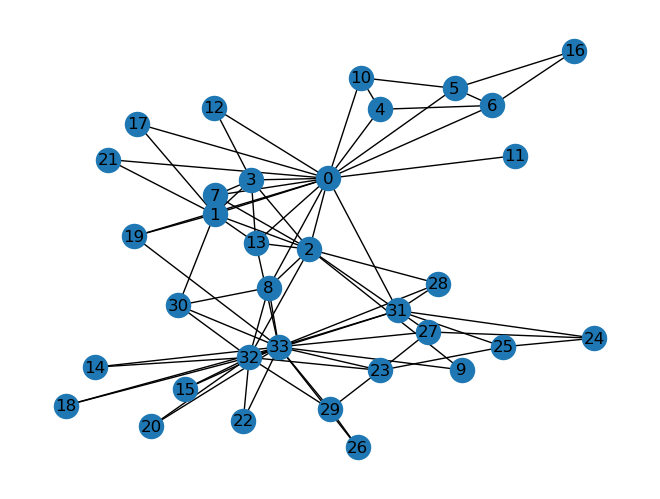

In [40]:
G = nx.karate_club_graph()

# G is an undirected graph
print(type(G))

# Visualize the graph
nx.draw(G, with_labels = True)

### Problem 5 (5 points)

Compute the average degree of the karate club network.

Instructions:
- Implement the `average_degree` function that takes the number of edges and nodes as input.
- Compute the average degree of the graph.
- Round the result to the nearest integer. For example, 3.3 will be rounded to 3 and 3.7 will be rounded to 4.

In [41]:
def average_degree(num_edges, num_nodes):
    """
    Args:
        num_edges: Number of edges in the graph
        num_nodes: Number of nodes in the graph

    Returns:
        avg_degree: Average degree of the graph
    """
    # START YOUR CODE HERE
    avg_degree = round(2 * num_edges / num_nodes)  # Compute the average degree
    # END YOUR CODE HERE
    return avg_degree

In [42]:
num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
print("Num edges:", num_edges, "Num nodeds:", num_nodes)
avg_degree = average_degree(num_edges, num_nodes)
print("Average degree of karate club network is {}".format(avg_degree))

Num edges: 78 Num nodeds: 34
Average degree of karate club network is 5


### Problem 6 (5 points)

Implement functions to compute the Laplacian and Random Walk matrices.

Instructions:
- Implement the `laplacian_matrix` function that takes the adjacency matrix as input and returns the Laplacian matrix.
- Implement the `random_walk_matrix` function that takes the adjacency matrix as input and returns the random walk matrix.

In [43]:

def laplacian_matrix(A):
    """
    Args:
        A: Adjacency matrix of the graph

    Returns:
        L: Laplacian matrix
    """
    # START YOUR CODE HERE
    D = np.diag(np.sum(A, axis=1))  # Compute the degree matrix
    L = D - A  # Compute the Laplacian matrix
    # END YOUR CODE HERE
    return L

def random_walk_matrix(A):
    """
    Args:
        A: Adjacency matrix of the graph

    Returns:
        P: Random walk matrix
    """
    # START YOUR CODE HERE
    D = np.diag(np.sum(A, axis=1))  # Compute the degree matrix
    P = np.linalg.inv(D) @ A  # Compute the random walk matrix
    # END YOUR CODE HERE
    return P

### Problem 7 (5 points)

Compute the PageRank value for node 0 after one PageRank iteration:

$$
r_j = \sum_{i \rightarrow j} \beta \frac{r_i}{d_i} + (1 - \beta) \frac{1}{N}
$$

Instructions:
- Implement the `one_iter_pagerank` function that takes the graph, damping factor, initial PageRank value, and node ID as input.
- Compute the PageRank value for the specified node after one iteration.
- Round the result to 2 decimal places.

In [44]:
def one_iter_pagerank(G, beta, r0, node_id):
    """
    Args:
        G: NetworkX graph
        beta: Damping factor
        r0: Initial PageRank value for each node
        node_id: Node to compute PageRank for

    Returns:
        r1: PageRank value after one iteration
    """
    # START YOUR CODE HERE
    r1 = 0  # Initialize the PageRank value
    for neighbor in G.neighbors(node_id):
        r1 += beta * r0 / G.degree[neighbor]  # Compute the contribution from each neighbor
    r1 += (1 - beta) / G.number_of_nodes()  # Add the teleportation term
    r1 = round(r1, 2)  # Round the result to 2 decimal places
    # END YOUR CODE HERE
    return r1

In [45]:
beta = 0.8
r0 = 1 / G.number_of_nodes()
node = 0
r1 = one_iter_pagerank(G, beta, r0, node)
print("The PageRank value for node 0 after one iteration is {}".format(r1))

The PageRank value for node 0 after one iteration is 0.13


### Problem 8 (5 points)

Compute the final PageRank values using the random walk matrix.

Instructions:
- Implement the `pagerank` function that takes the random walk matrix, number of iterations, and damping factor as input.
- Compute the final PageRank values using the power iteration method.
- Compare your results with the PageRank values obtained from NetworkX.


In [46]:
def pagerank(P, num_iterations=100, d=0.85):
    """
    Args:
        P: Random walk matrix
        num_iterations: Number of iterations
        d: Damping factor

    Returns:
        r: Final PageRank values
    """
    # START YOUR CODE HERE
    N = P.shape[0]  # Get the number of nodes
    r = np.ones(N) / N  # Initialize the PageRank values uniformly

    for _ in range(num_iterations):
        r_next = (1 - d) / N * np.ones(N) + d * np.dot(P.T, r)  # Update the PageRank values
        r = r_next

    # END YOUR CODE HERE
    return r

In [47]:
# Test case for pagerank function
G = nx.karate_club_graph()
P = random_walk_matrix(nx.adjacency_matrix(G).todense())
damping_factor = 0.85
num_iterations = 100

# Compute PageRank using the implemented pagerank function
pagerank_scores = pagerank(P, num_iterations, damping_factor)

# Compute PageRank using the NetworkX implementation
nx_pagerank_scores = nx.pagerank(G, alpha=damping_factor, max_iter=num_iterations)

# Convert NetworkX PageRank scores to a numpy array
nx_pagerank_scores = np.array(list(nx_pagerank_scores.values()))

print("Computed PageRank scores:")
print(pagerank_scores)

print("NetworkX PageRank scores:")
print(nx_pagerank_scores)

# Compare the computed PageRank scores with the NetworkX scores
assert np.allclose(pagerank_scores, nx_pagerank_scores, rtol=1e-3), "Computed PageRank scores do not match the NetworkX scores"

Computed PageRank scores:
[0.08850032 0.05741232 0.06276562 0.03721003 0.0205008  0.03380387
 0.03152302 0.0264632  0.03338248 0.00946349 0.02068568 0.009785
 0.01147426 0.03347292 0.0129424  0.01637744 0.01675226 0.0096767
 0.00954534 0.01307699 0.01122488 0.01135947 0.01296139 0.04114976
 0.01663573 0.02867645 0.01524172 0.02723773 0.01447923 0.02827467
 0.02303285 0.04198818 0.07593442 0.09698936]
NetworkX PageRank scores:
[0.08850807 0.05741484 0.06276686 0.03721208 0.02050398 0.03381044
 0.03152901 0.02646462 0.03338156 0.00946322 0.02068902 0.00978569
 0.01147487 0.03347419 0.0129416  0.01637633 0.0167554  0.00967727
 0.00954486 0.01307752 0.01122424 0.01136015 0.0129606  0.04114597
 0.01663437 0.02867296 0.01524039 0.02723536 0.01447852 0.02827181
 0.02303184 0.04198549 0.07592644 0.09698042]


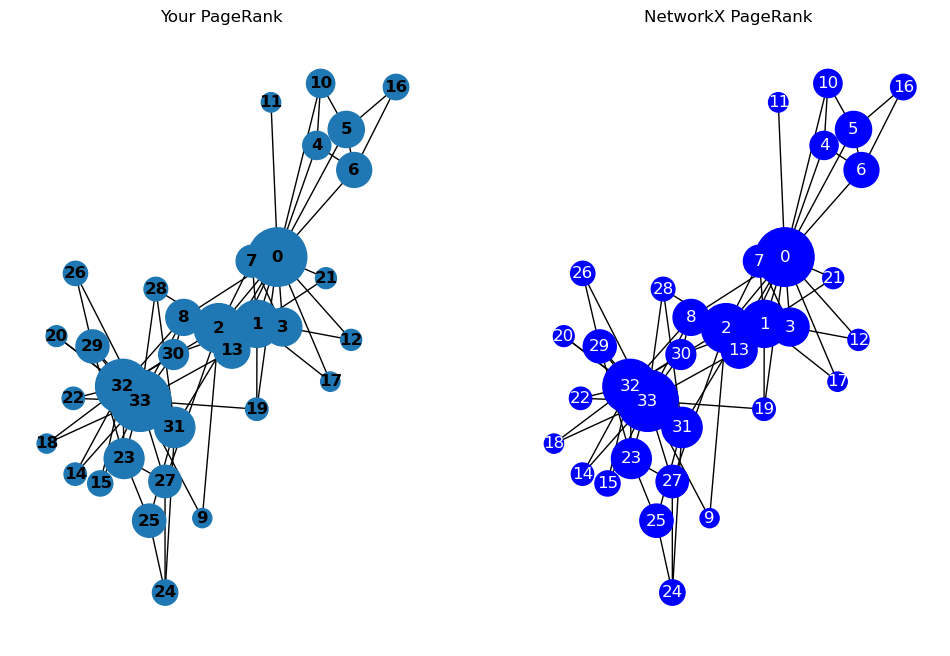

In [50]:
# Visualizing the graph with node sizes proportional to PageRank scores
node_sizes_custom = [20000 * pagerank_scores[i] for i in range(len(pagerank_scores))]  # Scale factor for visibility
node_sizes_nx = [20000 * nx_pagerank_scores[node] for node in G.nodes()]

pos = nx.spring_layout(G)

plt.figure(figsize=(12, 8))
plt.subplot(121)
nx.draw(G, pos, node_size=node_sizes_custom, with_labels=True, font_weight='bold')
plt.title("Your PageRank")

plt.subplot(122)
nx.draw(G, pos, node_size=node_sizes_nx, with_labels=True, font_color='white', node_color='blue')
plt.title("NetworkX PageRank")

plt.show()

### Problem 9 (10 points)
Implement negative edge sampling.

Instructions:
- Implement the `sample_negative_edges` function that takes a NetworkX graph and the number of negative samples as input.
- Sample negative edges that do not exist in the graph.
- Return the list of sampled negative edges.

Notes: You do not need to consider the corner case when the number of possible negative edges
is less than `num_neg_samples`. It should be ok as long as your implementation 
works on the karate club network. In this implementation, self loop should 
not be considered as either a positive or negative edge. Also, notice that 
the karate club network is an undirected graph, if (0, 1) is a positive 
edge, do you think (1, 0) can be a negative one?

In [51]:
def graph_to_edge_list(G):
    """
    Args:
        G: NetworkX graph

    Returns:
        edge_list: List of edges in the graph
    """
    edge_list = []
    for edge in G.edges():
        edge_list.append(edge)  # Append each edge to the edge list
    return edge_list

def edge_list_to_tensor(edge_list):
    """
    Args:
        edge_list: List of edges in the graph

    Returns:
        edge_index: Tensor of shape (2, num_edges)
    """
    edge_index = torch.tensor(edge_list).t().contiguous()  # Convert the edge list to a tensor and transpose it
    return edge_index


pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

def sample_negative_edges(G, num_neg_samples):
    """
    Args:
        G: NetworkX graph
        num_neg_samples: Number of negative examples to sample

    Returns:
        neg_edge_list: List of negative edges
    """
    # START YOUR CODE HERE
    neg_edge_list = []
    num_nodes = G.number_of_nodes()

    while len(neg_edge_list) < num_neg_samples:
        u = np.random.randint(0, num_nodes)  # Sample the first node randomly
        v = np.random.randint(0, num_nodes)  # Sample the second node randomly
        if u != v and not G.has_edge(u, v):
            neg_edge_list.append((u, v))  # Add the negative edge to the list if it doesn't exist in the graph
    # END YOUR CODE HERE
    return neg_edge_list

The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


In [52]:
# Sample 78 negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (1, 33)
edge_3 = (33, 22)
edge_4 = (0, 4)
edge_5 = (4, 2)

## Note:
## 1: For each of the 5 edges, print whether it can be negative edge
pos_edge_list = graph_to_edge_list(G)
for edge in [edge_1, edge_2, edge_3, edge_4, edge_5]:
    edge = (edge[1], edge[0]) if edge[0] > edge[1] else edge
    if edge in pos_edge_list:
        print("No")
    else:
        print("Yes")

The neg_edge_index tensor has shape torch.Size([2, 78])
No
Yes
No
No
Yes


### Problem 10 (15 points)

Train the node embedding model and report the best performance.

Instructions:
- Implement the `forward` method to compute the dot product of the embeddings for each edge.
- train the node embedding model using positive and negative edges.
- Use binary cross-entropy loss and optimize the model using Adam optimizer.
- Train the model for a specified number of epochs and report the best loss and accuracy achieved.
- Plot the training loss over epochs.
- Visualize the learned node embeddings in a 2D space using a scatter plot.

In [53]:
class EmbeddingModel(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(EmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_nodes, embedding_dim)  # Initialize the embedding layer

    def forward(self, edge):
        # START YOUR CODE HERE
        emb = self.embedding(edge)  # Get the embeddings for the nodes in the edge
        prod = torch.mul(emb[0], emb[1])  # Compute the element-wise product of the embeddings
        out = torch.sum(prod, dim=1)  # Sum the element-wise product to get the dot product
        # END YOUR CODE HERE
        return out

def train(model, pos_edge_index, neg_edge_index, num_epochs=500):
    """
    Args:
        model: Node embedding model
        pos_edge_index: Tensor of positive edges
        neg_edge_index: Tensor of negative edges
        num_epochs: Number of epochs to train for

    Returns:
        loss_history: List of training losses over epochs
        best_loss: Best loss achieved during training
        best_accuracy: Best accuracy achieved during training
        model: Trained model
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    pos_label = torch.ones(pos_edge_index.shape[1], dtype=torch.float)
    neg_label = torch.zeros(neg_edge_index.shape[1], dtype=torch.float)
    train_label = torch.cat([pos_label, neg_label], dim=0)
    train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)

    loss_history = []
    best_loss = float('inf')
    best_accuracy = 0.0
    loss_fn = nn.BCEWithLogitsLoss()  # Define the binary cross-entropy loss function

    for epoch in range(num_epochs):
        optimizer.zero_grad()  # Reset the gradients
        out = model(train_edge)  # Forward pass through the model
        
        loss = loss_fn(out, train_label)  # Compute the loss for the current epoch
        loss_history.append(loss.item())  # Append the loss to the list of losses

        loss.backward()  # Compute the gradients
        optimizer.step()  # Update the model parameters

        # Compute the accuracy
        pred = torch.sigmoid(out)
        pred_label = (pred > 0.5).float()
        accuracy = (pred_label == train_label).float().mean()

        # Update the best loss and accuracy
        if loss < best_loss:
            best_loss = loss.item()
            best_accuracy = accuracy.item()

    return loss_history, best_loss, best_accuracy, model

Best loss: 0.0016
Best accuracy: 1.0000


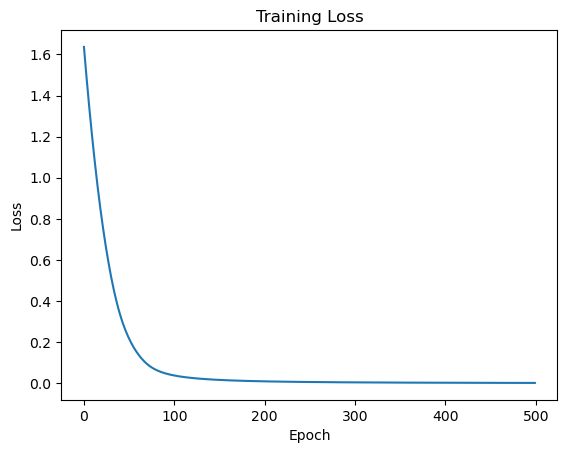

In [57]:
G = nx.karate_club_graph()
pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))
neg_edge_index = edge_list_to_tensor(neg_edge_list)

model = EmbeddingModel(G.number_of_nodes(), embedding_dim=16)
loss_history, best_loss, best_accuracy, model = train(model, pos_edge_index, neg_edge_index, num_epochs=500)

print(f"Best loss: {best_loss:.4f}")
print(f"Best accuracy: {best_accuracy:.4f}")

# Plot the training loss
plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

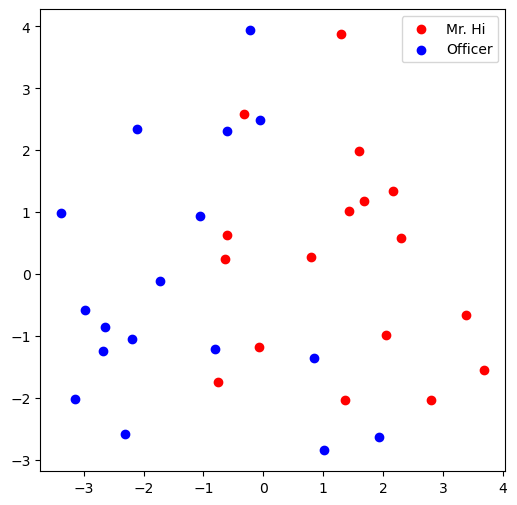

In [58]:
from sklearn.decomposition import PCA

X = model.embedding.weight.data.numpy()
pca = PCA(n_components=2)
components = pca.fit_transform(X)
plt.figure(figsize=(6, 6))
club1_x = []
club1_y = []
club2_x = []
club2_y = []
for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
        club1_x.append(components[node[0]][0])
        club1_y.append(components[node[0]][1])
    else:
        club2_x.append(components[node[0]][0])
        club2_y.append(components[node[0]][1])
plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
plt.scatter(club2_x, club2_y, color="blue", label="Officer")
plt.legend()
plt.show()

## Part 3: Spectral Clustering (10 points)

### Problem 11 (10 points)
Implement symmetric normalized spectral clustering.

Instructions:
- Implement the `spectral_clustering_sym` function that takes the adjacency matrix and the number of clusters as input.
- Compute the symmetric normalized Laplacian matrix.
- Compute the eigenvectors corresponding to the smallest eigenvalues of the normalized Laplacian matrix.
- Apply K-means clustering on the eigenvectors to obtain the cluster labels.

In [59]:
def spectral_clustering_rw(A, k):
    """
    Args:
        A: Adjacency matrix
        k: Number of clusters
    Returns:
        labels: Cluster labels
    """
    # START YOUR CODE HERE
    D = np.diag(np.sum(A, axis=1))  # Compute the degree matrix
    L = D - A  # Compute the unnormalized Laplacian matrix
    Dinv = np.linalg.pinv(D)  # Compute the inverse of the degree matrix
    Lrw = Dinv @ L  # Compute the random walk normalized Laplacian matrix

    _, vectors = scipy.linalg.eigh(Lrw, subset_by_index=[0, k-1])  # Compute the eigenvectors corresponding to the k smallest eigenvalues
    kmeans = KMeans(n_clusters=k).fit(vectors)  # Apply K-means clustering on the eigenvectors
    labels = kmeans.labels_  # Obtain the cluster labels
    # END YOUR CODE HERE
    return labels

In [60]:
G = nx.karate_club_graph()
A = nx.adjacency_matrix(G).todense()

labels_rw = spectral_clustering_rw(A, 4)

print(f"Random walk normalized Laplacian labels: {labels_rw}")

Random walk normalized Laplacian labels: [3 0 0 0 3 2 2 0 1 1 2 3 0 0 1 1 2 3 1 3 1 3 1 1 1 1 1 1 1 1 1 1 1 1]


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


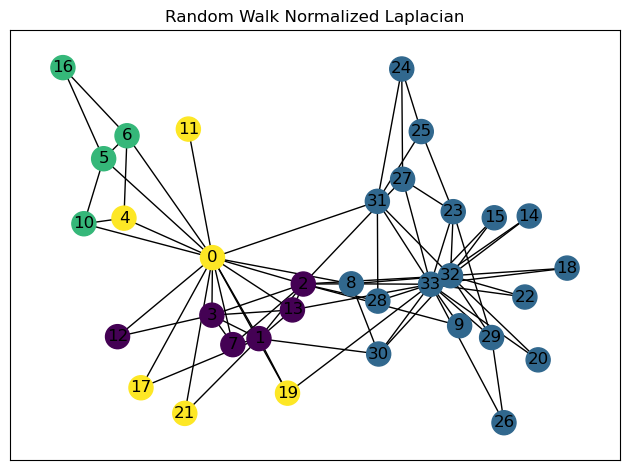

In [61]:
# Visualize the clusterings
pos = nx.spring_layout(G)


nx.draw_networkx(G, pos, node_color=labels_rw)
plt.title('Random Walk Normalized Laplacian') 

plt.tight_layout()
plt.show()